In [ ]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install matplotlib
!pip install numpy
!pip install pandas

# 2 CIFAR-10 Classification

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib as plt

(ds_train, ds_test), ds_info = tfds.load('cifar10', 
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         with_info=True)

ds_info

2022-12-03 21:11:37.631921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-03 21:11:37.633098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-03 21:11:37.633108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/home/studio-lab-user/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky

2022-12-03 21:11:43.604438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


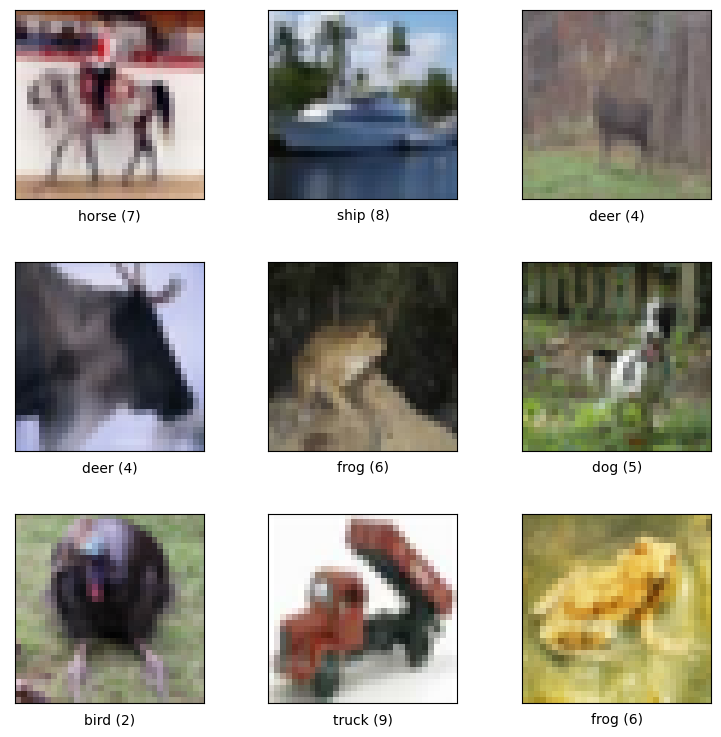

(1024, 3, 10)

In [3]:
tfds.show_examples(ds_train, ds_info)

img_size = ds_info.features['image'].shape[0] * ds_info.features['image'].shape[1]
img_channels = ds_info.features['image'].shape[2]
num_labels = ds_info.features['label'].num_classes

img_size, img_channels, num_labels

## 2.1 Prepare the dataset

In [4]:
def prepare_cifar10(ds, batch_size=32, shuffle_buffer_size=10000, prefetch_size=20):
    def normalize_img(image, label):
        return (tf.cast(image, tf.float32) / 128.) - 1, \
                tf.one_hot(label, depth=num_labels) 
    return ds.map(normalize_img) \
             .cache() \
             .shuffle(shuffle_buffer_size) \
             .batch(batch_size) \
             .prefetch(prefetch_size)
             
ds_train = prepare_cifar10(ds_train)
ds_test = prepare_cifar10(ds_test)

## 2.2 The CNN Model

In [5]:
class CNN(tf.keras.Model):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]
    
  def call(self, x):
    for layer in self.layer_list:
        x = layer(x)
    return x
  
def try_model(model, ds):
  for images, labels in ds.take(1):
    print(model(images).shape)

## 2.3 Training the network

In [9]:
model = CNN()
try_model(model, ds_test)

(32, 10)


In [10]:
def train(model, ds_train, ds_test, epochs=10):
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model.fit(ds_train, epochs=epochs, validation_data=ds_test)

In [11]:
model_history = train(model, ds_train, ds_test, 15)

Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.6656 - accuracy: 0.3815 - val_loss: 1.4108 - val_accuracy: 0.4877
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2850 - accuracy: 0.5387 - val_loss: 1.2028 - val_accuracy: 0.5705
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1120 - accuracy: 0.6053 - val_loss: 1.0638 - val_accuracy: 0.6234
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0146 - accuracy: 0.6415 - val_loss: 0.9770 - val_accuracy: 0.6514
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9401 - accuracy: 0.6691 - val_loss: 0.9021 - val_accuracy: 0.6830
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8858 - accuracy: 0.6901 - val_loss: 0.8775 - val_accuracy: 0.6930
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8306 - accuracy: 0.7081 - val_loss: 0.8246 - val_accuracy:

## 2.4 Visualization

<AxesSubplot: >

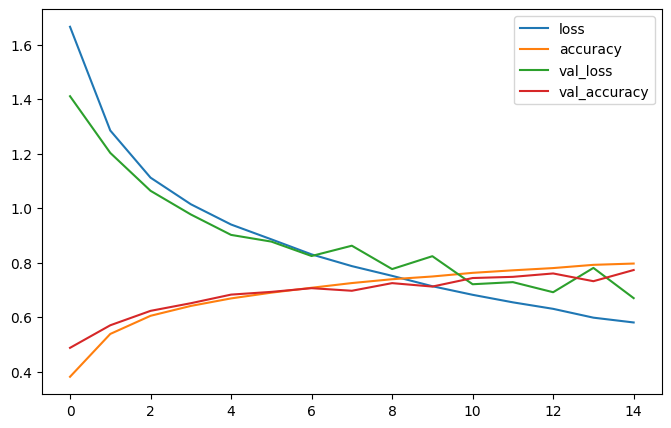

In [12]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))

## 3 Adjust hyperparameters and architecture

In [13]:
class ResConv2DLayer(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ResConv2DLayer, self).__init__()
        self.layer = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding='same', activation='relu')
        
    def call(self, x):
        return self.layer(x) + x
    
class ResConv2DBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, num_layers):
        super(ResConv2DBlock, self).__init__()
        self.layer = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding='same', activation='relu')
        self.layers = [ResConv2DLayer(num_filters) for _ in range(num_layers)]
        
    def call(self, x):
        x = self.layer(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [26]:
class ResCNN3(CNN):
  def __init__(self):
    super(ResCNN3, self).__init__()
    
    self.layer_list = [
      ResConv2DBlock(num_filters=32, num_layers=4),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
      ResConv2DBlock(num_filters=64, num_layers=4),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
      ResConv2DBlock(num_filters=128, num_layers=4),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]
tf.keras.utils.set_random_seed(133742069)

model_res3 = ResCNN3()
try_model(model_res3, ds_test)
hst = train(model_res3, ds_train, ds_test, epochs=20)

(32, 10)
Epoch 1/20
1563/1563 [==============================] - 22s 11ms/step - loss: 1.6146 - accuracy: 0.3786 - val_loss: 1.2486 - val_accuracy: 0.5339
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0882 - accuracy: 0.6045 - val_loss: 0.9782 - val_accuracy: 0.6629
Epoch 3/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8465 - accuracy: 0.6994 - val_loss: 0.8292 - val_accuracy: 0.7107
Epoch 4/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6985 - accuracy: 0.7558 - val_loss: 0.8343 - val_accuracy: 0.7087
Epoch 5/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6087 - accuracy: 0.7869 - val_loss: 0.7195 - val_accuracy: 0.7553
Epoch 6/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5331 - accuracy: 0.8131 - val_loss: 0.6543 - val_accuracy: 0.7776
Epoch 7/20
1563/1563 [==============================] - 17s 11ms/step - loss: 0.4703 - accuracy: 0.8369 - val_loss:

<AxesSubplot: >

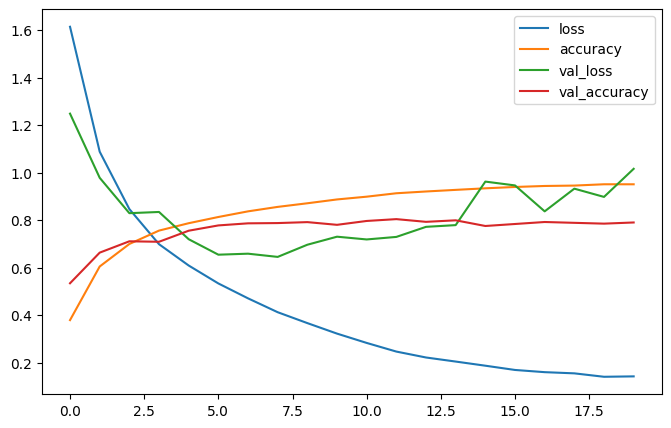

In [27]:
pd.DataFrame(hst.history).plot(figsize=(8,5))

$\implies$ the model is currently overfitting.